In [48]:
import sys

import torch

sys.path.append("../")
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from lib.datasets import HomogeneousPipelineDataset
from lib.models import HomogeneousGCN
from lib.pl import LightningModule
import matplotlib.pyplot as plt
import numpy as np

In [49]:
model = LightningModule.load_from_checkpoint(
    r"C:\Users\Konstantin\PycharmProjects\NIR\experiments\homogeneous_gcn\pipeline_dataset\g3_8__m2_8__sum_agg__clip__lr_0.001__edge_direction_undirected__use_operations_hyperparameters\version_0\checkpoints\last.ckpt",
    model=HomogeneousGCN(
        in_channels=60,
        out_channels=2,
        gnn_num_layers=3,
        gnn_hidden_channels=8,
        mlp_num_layers=2,
        mlp_hidden_channels=8,
        aggregation="sum",
        clip_output=(0., 1.)
    ),
    loss=F.mse_loss,
    lr=1e-3,
    )
model = model.eval()

In [50]:
dataset = HomogeneousPipelineDataset(
    root=r"C:\Users\Konstantin\PycharmProjects\NIR\dataset\pipeline_dataset",
    split=None,
    direction="undirected",
    use_operations_hyperparameters=True
)
loader = DataLoader(
    dataset,
    batch_size=1024,
    shuffle=False,
)

In [51]:
preds = []
gt = []
for batch in iter(loader):
    x, y = batch
    with torch.no_grad():
        pred = model.model(x).numpy()
    pred_scaled_back = dataset._metrics_scaler.inverse_transform(pred)
    gt_scaled_back = dataset._metrics_scaler.inverse_transform(y)
    gt.append(gt_scaled_back)
    preds.append(pred_scaled_back)

In [52]:
pred_roc_auc, pred_f1 = np.vstack(preds).T
roc_auc, f1 = np.vstack(gt).T

In [53]:
mean_roc_auc = np.mean(roc_auc)
mean_f1 = np.mean(f1)
print("Mean roc_auc: ", mean_roc_auc)
print("Mean f1: ", mean_f1)

Mean roc_auc:  0.9189877079999373
Mean f1:  0.7434530293208174


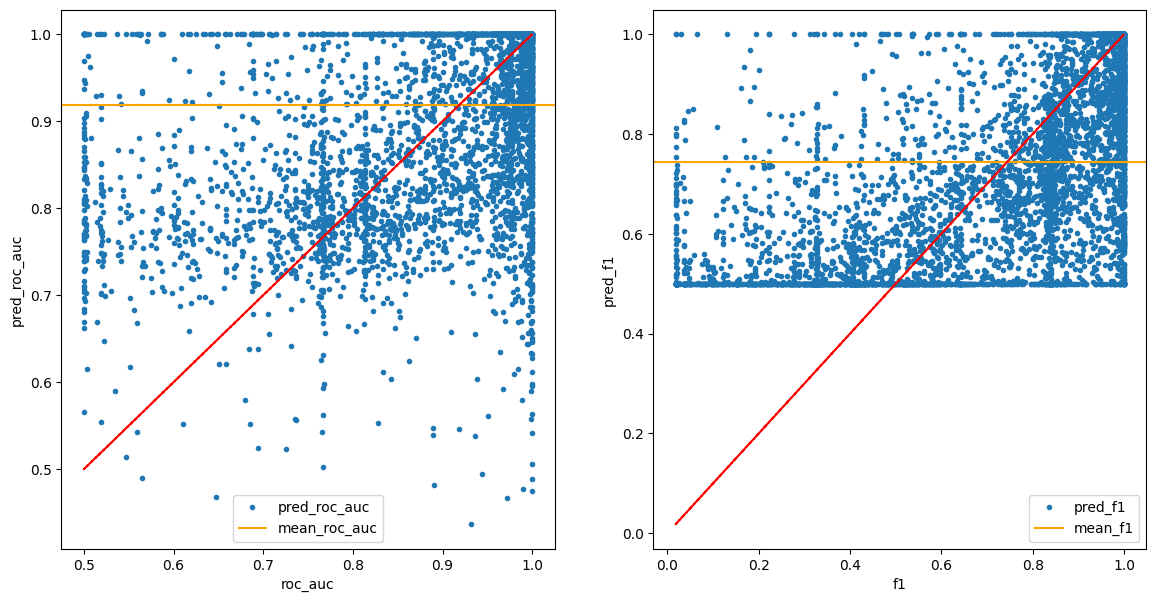

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(roc_auc, pred_roc_auc, ls="", marker=".", label="pred_roc_auc")
ax[0].axhline(y=mean_roc_auc, c="orange", label="mean_roc_auc")
ax[0].plot(roc_auc, roc_auc, ls="--", c="red")
ax[0].set_xlabel("roc_auc")
ax[0].set_ylabel("pred_roc_auc")
ax[0].legend()
ax[1].plot(f1, pred_f1, ls="", marker=".", label="pred_f1")
ax[1].axhline(y=mean_f1, c="orange", label="mean_f1")
ax[1].plot(f1, f1, ls="--", c="red")
ax[1].set_xlabel("f1")
ax[1].set_ylabel("pred_f1")
ax[1].legend()
plt.show()

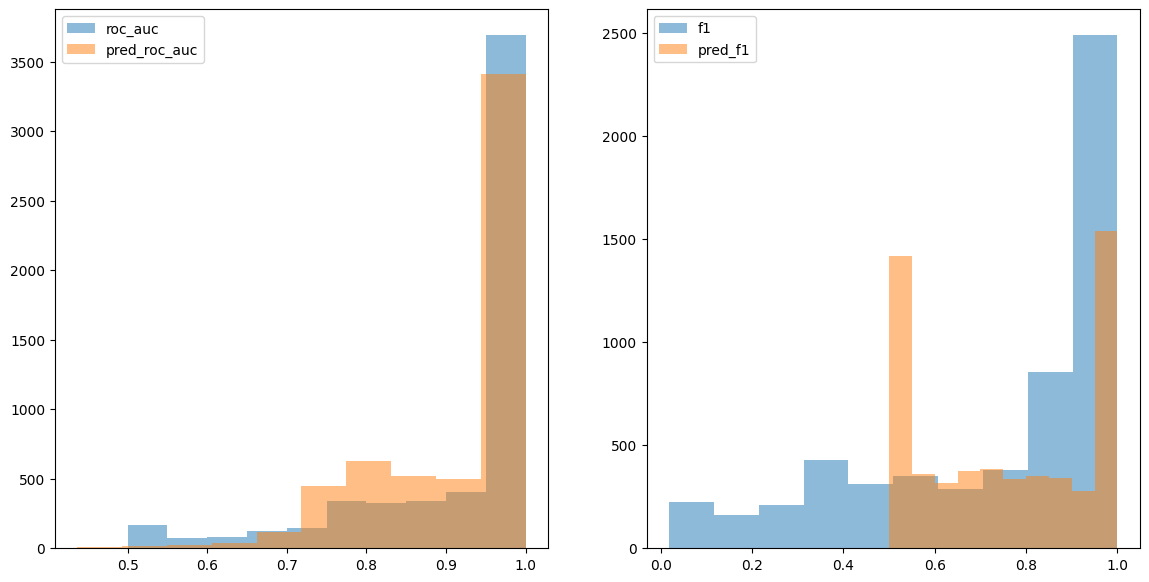

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].hist(roc_auc, label="roc_auc", alpha=0.5)
ax[0].hist(pred_roc_auc, label="pred_roc_auc", alpha=0.5)
ax[0].legend()
ax[1].hist(f1, label="f1", alpha=0.5)
ax[1].hist(pred_f1, label="pred_f1", alpha=0.5)
ax[1].legend()
plt.show()

In [56]:
# roc_auc loss
print(F.mse_loss(torch.tensor(roc_auc).reshape(-1, 1), torch.tensor(pred_roc_auc).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(roc_auc).reshape(-1, 1), torch.tensor([mean_roc_auc] * len(roc_auc)).reshape(-1, 1)))

tensor(0.0121, dtype=torch.float64)
tensor(0.0155, dtype=torch.float64)


In [57]:
# f1 loss
print(F.mse_loss(torch.tensor(f1).reshape(-1, 1), torch.tensor(pred_f1).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(f1).reshape(-1, 1), torch.tensor([mean_f1] * len(roc_auc)).reshape(-1, 1)))

tensor(0.0443, dtype=torch.float64)
tensor(0.0832, dtype=torch.float64)


In [58]:
# Joined loss
print(F.mse_loss(torch.tensor(np.vstack([roc_auc, f1])).reshape(-1, 1),
                 torch.tensor(np.vstack([pred_roc_auc, pred_f1])).reshape(-1, 1)))
print(F.mse_loss(torch.tensor(np.vstack([roc_auc, f1])).reshape(-1, 1),
                 torch.tensor([mean_roc_auc, mean_f1] * len(roc_auc)).reshape(-1, 1)))


tensor(0.0282, dtype=torch.float64)
tensor(0.0646, dtype=torch.float64)
